In [ ]:
from typing import Annotated,Literal
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages
from pydantic import BaseModel,Field
from typing_extensions import TypedDict

# Simple Agent

In [47]:
class State(TypedDict):
    message: Annotated[list,add_messages]

graph_builder = StateGraph(State)

def chatbot(state: State) -> State:
    return {"message":[f"Hello User ! {state['message'][-1].content}"]}

graph_builder.add_node("chatbot1",chatbot)

graph_builder.add_edge(START,"chatbot1")
graph_builder.add_edge("chatbot1",END)

In [48]:
graph = graph_builder.compile()
user_input = "Focus"
state = graph.invoke({"message":[{"role":"user",
                    "content":user_input}]})
                    
print(state["message"][-1].content)

Hello User ! Focus


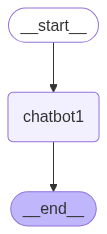

In [49]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

# Routing

In [50]:
msg = MessageClassifier(message_type="emotional")
print(msg.message_type)
# Output: emotional

emotional


In [ ]:
class MessageClassifier(BaseModel):
    message_type: Literal["emotional","logical"] = Field(
        ...,
        description="Classify if the message require an emotional(therapist) or logical response"
    )

class State(TypedDict):
    message: Annotated[list,add_messages]
    message_type: str | None

def classify_message(state: State) -> State:
    last_message = state["message"][-1]
    classifier_llm = MessageClassifier(message_type=last_message.content) #must write classifier llm/basic encoder
    result = classifier_llm
    return {"message_type":result.message_type} #will auto update in State

def router(state: State) -> State:
    message_type = state.get("message_type","default")
    if message_type == "emotional":
        return {"next":"therapist"}

    return {"next":"logical"}

def therapist_agent(state: State) -> State:
    last_message = state["message"][-1]
    message = f"Hello User I'm a therapist agent! {last_message.content}"
    return {"message":[message]}

def logical_agent(state: State) -> State:
    last_message = state["message"][-1]
    message = f"Hello User I'm a logical agent ! {last_message.content}"
    return {"message":[message]}

graph_builder = StateGraph(State)

graph_builder.add_node("classifier",classify_message)
graph_builder.add_node("router",router)
graph_builder.add_node("logical_agent",logical_agent)
graph_builder.add_node("therapist_agent",therapist_agent)

graph_builder.add_edge(START,"classifier")
graph_builder.add_edge("classifier","router")

graph_builder.add_conditional_edges(
    "router",
    lambda state: state.get("next"),
    {
        "logical": "logical_agent",
        "therapist": "therapist_agent"
    }
)
graph_builder.add_edge("logical_agent",END)
graph_builder.add_edge("therapist_agent",END)
graph = graph_builder.compile()

In [57]:
user_input = "emotional"
state = graph.invoke({"message":[{"role":"user",
                    "content":user_input}]})
                    
print(state["message"][-1].content)

Hello User I'm a therapist agent! emotional


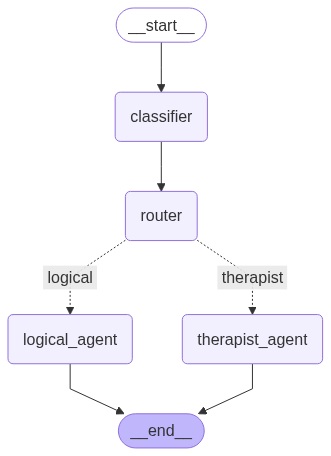

In [58]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png(max_retries=10)))